In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from scipy.signal import find_peaks
from scipy.signal import peak_widths

run_number = 3

# Filter out the light-adapted strips

In [2]:
trial_number = 2


# output\trial_1\081624_rois_metadata_bignine.csv
metadata_all = pd.read_csv(f"./output/trial_{trial_number}/081624_rois_metadata_bignine.csv")

metadata = metadata_all.copy()

# remove the light adapted strips. 
# 1. lower case the filename
metadata['filename'] = metadata['filename'].str.lower()
print(f"Before filtering out light-adapted images there are {len(metadata['filename'])} strips in the metadata.\n")

# 2. remove rows that don't contain 'dark'
metadata = metadata[metadata['filename'].str.contains('dark')]
print(f"After filtering, there are {len(metadata['filename'])} remaining.\n")

# get the strip numbers of the dark adapted strips
strip_filenames = metadata['strip_filename'].unique()

print(f"These are the remaining strips:")
for strip in metadata['strip_filename'].unique():
    print(f"\t{strip}")
    
# get the strips that were filtered out by comparing the strip_filenames in the metadata_all with the strip_numbers
filtered_out = metadata_all[~metadata_all['strip_filename'].isin(strip_filenames)]

print(f"These are the strips that were filtered out:")
for strip in filtered_out['strip_filename'].unique():
    print(f"\t{strip}")
    
    
# create a list of the isolated numbers from the strip filenames
strip_numbers = [int(strip.strip(".png").split('_')[-1]) for strip in strip_filenames]
print(f"\nThese are the strip numbers of the remaining strips: {strip_numbers}")

Before filtering out light-adapted images there are 9 strips in the metadata.

After filtering, there are 8 remaining.

These are the remaining strips:
	strip_106.png
	strip_134.png
	strip_135.png
	strip_161.png
	strip_176.png
	strip_187.png
	strip_229.png
	strip_232.png
These are the strips that were filtered out:
	strip_101.png

These are the strip numbers of the remaining strips: [106, 134, 135, 161, 176, 187, 229, 232]


# Filter the lumen df to only include the dark-adapted strips.

In [3]:
# load the lumen datafile with pd
lumen_data = pd.read_csv(f"./output/trial_{trial_number}/csv/lumen_{run_number}.csv")

# print the length of the df 
print(f"Before filtering out the light-adapted strips, there are {len(lumen_data)} rows in the lumen data.\n")

# get the lumen data for the strips that were not filtered out
lumen_data = lumen_data[lumen_data['strip'].isin(strip_numbers)]

print(f"After filtering, there are {len(lumen_data)} remaining.\n")

Before filtering out the light-adapted strips, there are 348 rows in the lumen data.

After filtering, there are 318 remaining.



# get the threshold metadata so we can reference it

In [4]:
th_metadata = pd.read_csv(f"./output/trial_{trial_number}/threshold_metadata_{run_number}.csv", index_col=0)
th_metadata["process"] = th_metadata.index
print(th_metadata.head())

                  method  morph_key  equalize  blur  thresh  maxval  \
0_otsuOffset  otsuOffset  closeOpen      True  True      90     255   
1_otsuOffset  otsuOffset  closeOpen      True  True      90     255   
2_otsuOffset  otsuOffset  closeOpen      True  True     100     255   
3_otsuOffset  otsuOffset  closeOpen      True  True     100     255   
4_otsuOffset  otsuOffset  closeOpen      True  True     130     255   

              blocksize  c                                         morph_args  \
0_otsuOffset         25  2  {'name': 'closeOpen', 'closing_kernel': array(...   
1_otsuOffset         25  2  {'name': 'closeOpen', 'closing_kernel': array(...   
2_otsuOffset         25  2  {'name': 'closeOpen', 'closing_kernel': array(...   
3_otsuOffset         25  2  {'name': 'closeOpen', 'closing_kernel': array(...   
4_otsuOffset         25  2  {'name': 'closeOpen', 'closing_kernel': array(...   

              offset           key       process  
0_otsuOffset    1.18  0_otsuOffset 

# calculate the mean width of the lumen, grouped by the process

6
process
0_otsuOffset    4.858823
1_otsuOffset    4.709836
2_otsuOffset    4.858823
3_otsuOffset    4.709836
4_otsuOffset    4.858823
Name: lumen_width_nm, dtype: float64


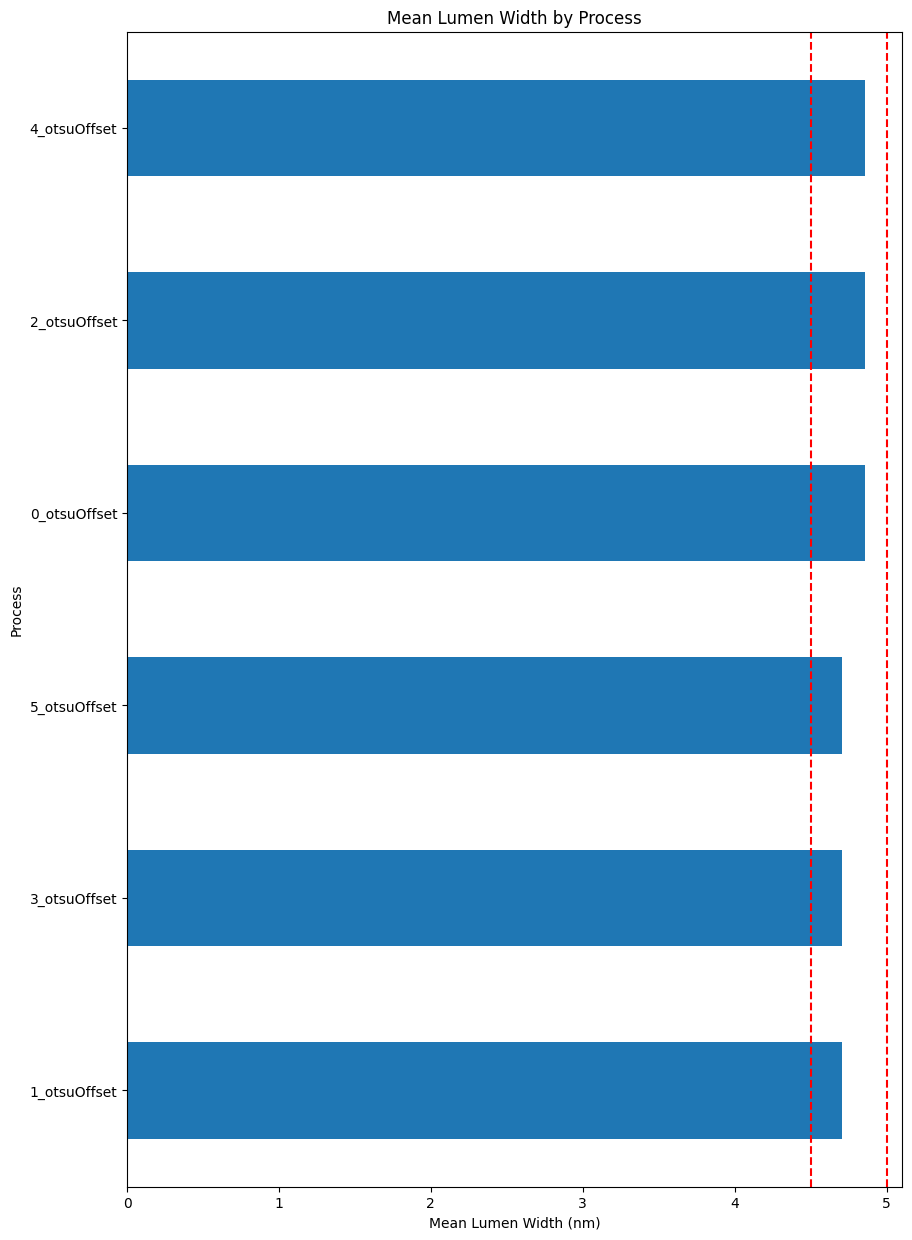

In [5]:

# we need to get the mean width of the lumen for each image, but grouped by process. this is a groupby operation
mean_widths = lumen_data.groupby('process')['lumen_width_nm'].mean()

print(len(mean_widths))
print(mean_widths.head())

# sort the mean widths
mean_widths = mean_widths.sort_values()
expected_range = [4.5, 5]

# plot the mean widths. figsize the first number is the width, the second is the height
plt.figure(figsize=(10, 15))
mean_widths.plot(kind='barh')
plt.xlabel('Mean Lumen Width (nm)')
plt.ylabel('Process')
plt.title('Mean Lumen Width by Process')

# mark a dashed vertical line at the low and high end of the expected range
plt.axvline(expected_range[0], color='r', linestyle='--')
plt.axvline(expected_range[1], color='r', linestyle='--')

plt.show()

# Take a closer look at those in the range

In [6]:
# print the processes in mean_width that are within the range +/- 0.5 nm
# adjusted_range = [expected_range[0] - 0.5, expected_range[1] + 0.5]
adjusted_range = [expected_range[0], expected_range[1]]

adj_mean_widths = mean_widths[mean_widths.between(adjusted_range[0], adjusted_range[1])]
print(adj_mean_widths)
print(type(adj_mean_widths))

process
1_otsuOffset    4.709836
3_otsuOffset    4.709836
5_otsuOffset    4.709836
0_otsuOffset    4.858823
2_otsuOffset    4.858823
4_otsuOffset    4.858823
Name: lumen_width_nm, dtype: float64
<class 'pandas.core.series.Series'>


In [7]:
# get the index for the processes that are within the range
adj_processes = adj_mean_widths.index
print(adj_processes)

Index(['1_otsuOffset', '3_otsuOffset', '5_otsuOffset', '0_otsuOffset',
       '2_otsuOffset', '4_otsuOffset'],
      dtype='object', name='process')


In [8]:
# take the index of the th_metadata and create a column
th_metadata['in_range'] = th_metadata.index.isin(adj_processes)
print(len(th_metadata))

# filter the th_metadata to only include the processes that are in the range
df = th_metadata[th_metadata['in_range']].copy()
print(len(df))

6
6


# The best results

In [9]:
# merge the series into the df, joining on the process column
df = df.merge(adj_mean_widths, left_on='process', right_index=True)
df
df.to_csv(f"./output/trial_{trial_number}/threshold_metadata_{run_number}_filtered.csv")

In [10]:
import os
import shutil
import glob

# Isolate the data that has blurring and equalization, and has an offset within 1.2 and 1.17
df = df[(df['blur'] == True) & (df['equalize'] == True) & (df['offset'].between(1.17, 1.2))]

print(len(df))

# print out the process names in a list:
for process in df['process']:
    print(process)
    
    


6
0_otsuOffset
1_otsuOffset
2_otsuOffset
3_otsuOffset
4_otsuOffset
5_otsuOffset


In [11]:
# Initialize an empty list to store the summary lines
summary_lines = []

# For each process, print out the lumen width for each strip and the overall mean lumen width
for process in df['process']:
    summary_lines.append(f"Process {process}:")
    
    process_df = lumen_data[lumen_data['process'] == process]
    
    # Initialize a list to store the mean lumen widths for each strip
    strip_mean_lumen_widths = []
    
    for strip in process_df['strip'].unique():
        strip_df = process_df[process_df['strip'] == strip]
        mean_lumen_width = strip_df['lumen_width_nm'].mean()
        strip_mean_lumen_widths.append(mean_lumen_width)
        summary_lines.append(f"  Strip {strip}: Mean lumen width: {mean_lumen_width:.2f} nm")
    
    # Calculate the overall mean lumen width for the process
    overall_mean_lumen_width = sum(strip_mean_lumen_widths) / len(strip_mean_lumen_widths)
    summary_lines.append(f"  Overall mean lumen width: {overall_mean_lumen_width:.2f} nm")
    summary_lines.append("\n")

# Join the summary lines into a single string
summary = "\n".join(summary_lines)

# Print the summary (or you can use it in an email)
print(summary)

Process 0_otsuOffset:
  Strip 106: Mean lumen width: 4.93 nm
  Strip 134: Mean lumen width: 4.25 nm
  Strip 135: Mean lumen width: 4.34 nm
  Strip 161: Mean lumen width: 4.19 nm
  Strip 176: Mean lumen width: 4.80 nm
  Strip 187: Mean lumen width: 5.09 nm
  Strip 229: Mean lumen width: 4.87 nm
  Strip 232: Mean lumen width: 5.64 nm
  Overall mean lumen width: 4.76 nm


Process 1_otsuOffset:
  Strip 106: Mean lumen width: 4.76 nm
  Strip 134: Mean lumen width: 4.06 nm
  Strip 135: Mean lumen width: 4.24 nm
  Strip 161: Mean lumen width: 4.02 nm
  Strip 176: Mean lumen width: 4.70 nm
  Strip 187: Mean lumen width: 5.02 nm
  Strip 229: Mean lumen width: 4.72 nm
  Strip 232: Mean lumen width: 5.54 nm
  Overall mean lumen width: 4.63 nm


Process 2_otsuOffset:
  Strip 106: Mean lumen width: 4.93 nm
  Strip 134: Mean lumen width: 4.25 nm
  Strip 135: Mean lumen width: 4.34 nm
  Strip 161: Mean lumen width: 4.19 nm
  Strip 176: Mean lumen width: 4.80 nm
  Strip 187: Mean lumen width: 5.09 nm


In [12]:
import pandas as pd

# Initialize an empty list to store the summary data
summary_data = []

# For each process, collect the lumen width for each strip and the overall mean lumen width
for process in df['process']:
    process_df = lumen_data[lumen_data['process'] == process]
    
    # Initialize a list to store the mean lumen widths for each strip
    strip_mean_lumen_widths = []
    
    for strip in process_df['strip'].unique():
        strip_df = process_df[process_df['strip'] == strip]
        mean_lumen_width = strip_df['lumen_width_nm'].mean()
        strip_mean_lumen_widths.append(mean_lumen_width)
        summary_data.append([process, strip, mean_lumen_width])
    
    # Calculate the overall mean lumen width for the process
    overall_mean_lumen_width = sum(strip_mean_lumen_widths) / len(strip_mean_lumen_widths)
    summary_data.append([process, 'Overall', overall_mean_lumen_width])

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data, columns=['Process', 'Strip', 'Mean Lumen Width (nm)'])

# Save the DataFrame to a CSV file
summary_df.to_csv('lumen_width_summary.csv', index=False)

# Print the DataFrame (optional)
print(summary_df)

         Process    Strip  Mean Lumen Width (nm)
0   0_otsuOffset      106               4.925780
1   0_otsuOffset      134               4.251912
2   0_otsuOffset      135               4.336292
3   0_otsuOffset      161               4.188437
4   0_otsuOffset      176               4.796862
5   0_otsuOffset      187               5.089039
6   0_otsuOffset      229               4.870395
7   0_otsuOffset      232               5.636265
8   0_otsuOffset  Overall               4.761873
9   1_otsuOffset      106               4.756129
10  1_otsuOffset      134               4.062932
11  1_otsuOffset      135               4.237567
12  1_otsuOffset      161               4.017216
13  1_otsuOffset      176               4.695376
14  1_otsuOffset      187               5.021790
15  1_otsuOffset      229               4.717101
16  1_otsuOffset      232               5.538405
17  1_otsuOffset  Overall               4.630815
18  2_otsuOffset      106               4.925780
19  2_otsuOffset    

# Lets provide some visual feedback, showing the contours of the membranes on the original roi images.

In [13]:

def getMembraneImage(process_folder: str, strip_name: str) -> np.ndarray:
    """
    Get the membrane image for a given process.
    
    Args:
        process_folder: The folder of the process (e.g., ./output/trial_1/processed_images/process_1).
        strip_name: The name of the strip image file (e.g., 'strip_101.png').
    
    Returns:
        The membrane image as a NumPy array.
    """
    # Get the path to the membrane image
    membrane_image_path = os.path.join(process_folder, 'membrane', strip_name)
    
    # Load the membrane image
    membrane_image = cv2.imread(membrane_image_path, cv2.IMREAD_GRAYSCALE)
    
    return membrane_image

def getRawImage(roi_folder: str, strip_name: str) -> np.ndarray:
    """
    Get the raw image for a given strip.
    
    Args:
        strip_name: The name of the strip.
    
    Returns:
        The raw image as a NumPy array, converted to RGB.
        
    """
    # Get the path to the raw image
    raw_image_path = os.path.join(roi_folder, strip_name)
    
    # Load the raw image
    raw_image = cv2.imread(raw_image_path, cv2.IMREAD_GRAYSCALE)
    
    # convert to a rgb image
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
    
    return raw_image


In [14]:
# look at the images in the poi folder
# D:\repos\gapfinder_images\output\trial_1\poi\106_otsuOffset\membrane\strip_101.png

# get the contents of the poi folder, but only the folder names
poi_folder = f"./output/trial_{trial_number}/processed_images"
roi_folder = f"./output/trial_{trial_number}/rois"

process_folders = [f.path for f in os.scandir(poi_folder) if f.is_dir()]

# get the strip filenames from the metadata bignine
metadata = pd.read_csv(f"./output/trial_{trial_number}/081624_rois_metadata_bignine.csv")
strip_filenames = metadata['strip_filename'].unique()

# create a dict of the roi_images and their filenames
roi_images = {}

for strip in strip_filenames:
    roi_images[strip] = getRawImage(roi_folder, strip)
    
print(len(roi_images))
for key in roi_images.keys():
    print(key)

9
strip_101.png
strip_106.png
strip_134.png
strip_135.png
strip_161.png
strip_176.png
strip_187.png
strip_229.png
strip_232.png


# Produce images that show the contours on the raw images
for each of the processes, we will get the membrane image, get the contours, and then draw the contours on top of the original image.
Then save that image in the process folder, in the subfolder "contours". The filename will be the strip filename.

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
./output/trial_2/processed_images\0_otsuOffset
(120, 60)
(120, 60, 3)
[26 39 52 66 81 94]
(120, 60, 3)


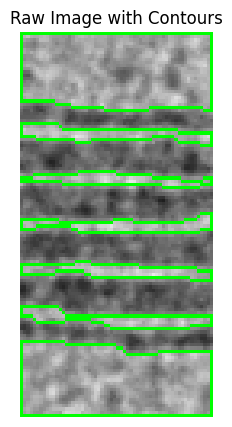

In [15]:

def getMembraneDf(poi_folder: str, strip: str) -> pd.DataFrame:
    """
    Get the membrane data for the POI.
    
    Args:
        poi_folder: The folder of the POI (e.g., ./output/trial_1/poi/process_1).
    
    Returns:
        A DataFrame containing the membrane data.
    """
    # Get the path to the membrane data file
    membrane_data_path = os.path.join(poi_folder, 'grana_data_membrane.csv')
    print(f"Membrane data path: {membrane_data_path}")
    # Load the membrane data
    membrane_data = pd.read_csv(membrane_data_path) 
    print(f"len(membrane_data): {len(membrane_data)}")
    # isolate the numeric portion of the strip 
    strip1 = int(strip.split('_')[-1].strip('.png')) 
    print(f"Strip: {strip1}")
    
    # filter to only include the strip
    membrane_data = membrane_data[membrane_data['strip'] == strip1]
    
    return membrane_data


def drawContours(membrane_image, raw_image: np.ndarray, color: tuple = (0, 255, 0), thickness: int = 1, df: pd.DataFrame = None) -> np.ndarray:
    """
    Draw the contours of the membrane on the raw image.
    
    Args:
        membrane_image: The membrane image as a NumPy array.
        raw_image: The raw image as a NumPy array.
        color: The color of the contours.
    
    Returns:
        The raw image with the contours drawn on it.
    """
    
    # inv the membrane image so that the contours work properly
    _, inv_membrane_image = cv2.threshold(membrane_image, 127, 255, cv2.THRESH_BINARY_INV)

    # Find the contours in the membrane image
    contours, _ = cv2.findContours(inv_membrane_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the raw image (-1 means all contours)
    raw_image_with_contours = cv2.drawContours(raw_image.copy(), contours, -1, color, thickness)
    
    if df is not None:
        # get the peaks from the df
        peaks = df['peaks'].values
        # for each peak, plot the peak number at the y value of the peak
        for i, peak in enumerate(peaks):
            
            # draw a dashed blue line at the peak
            cv2.line(raw_image_with_contours, (0, peak), (raw_image_with_contours.shape[1], peak), (0, 0, 255), 1, cv2.LINE_8, 0)    
        
            # add a text label for the peak, in red
            cv2.putText(raw_image_with_contours, f"{i}", (raw_image_with_contours.shape[1] - 10, peak), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            

    return raw_image_with_contours

# Get the membrane image for the first process and strip
#first process in process_folders
process = process_folders[0]
strip = strip_filenames[0]
df = getMembraneDf(process, strip)

print(process)
membrane_image = getMembraneImage(process, strip)
print(membrane_image.shape)

# Get the raw image for the strip
raw_image = getRawImage(roi_folder, strip)
print(raw_image.shape)

# Draw the contours of the membrane on the raw image
raw_image_with_contours = drawContours(membrane_image, raw_image, color=(0, 255, 0), thickness=1)

# get the peak values for this strip and process from the membrane data
peaks = df['peaks'].values
print(peaks)

print(raw_image_with_contours.shape)
# Display the raw image with contours
plt.figure(figsize=(5, 5))

plt.imshow(raw_image_with_contours)
plt.axis('off')
plt.title('Raw Image with Contours')
plt.show()

# now do that for each process folder, for each strip name

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_101.png


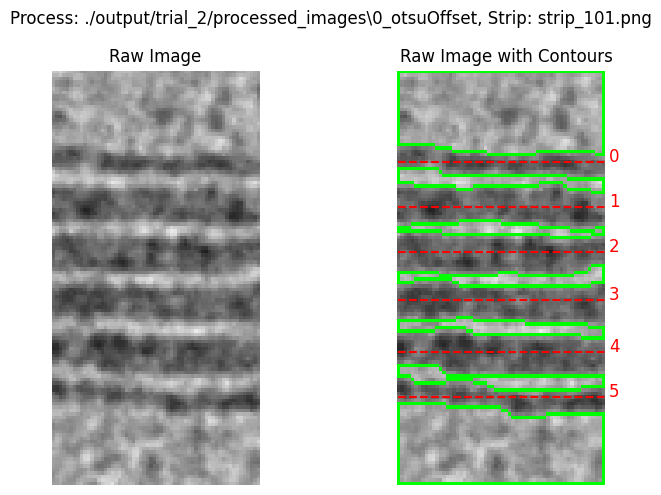

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 106
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_106.png


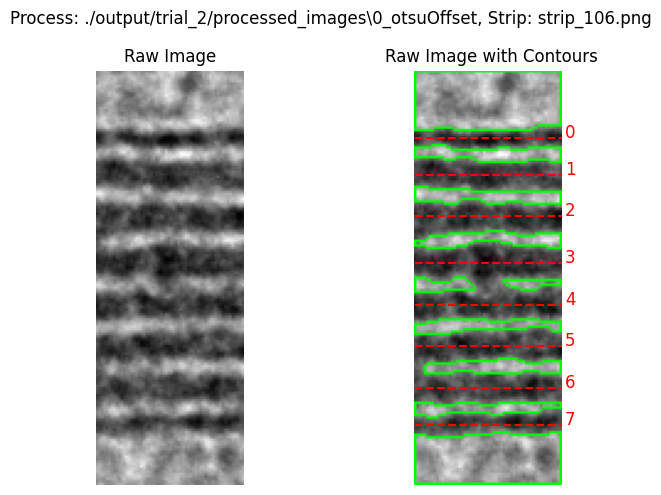

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 134
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_134.png


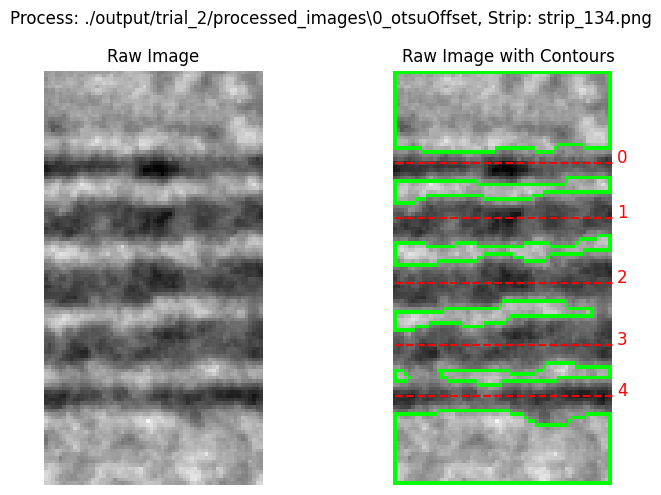

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 135
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_135.png


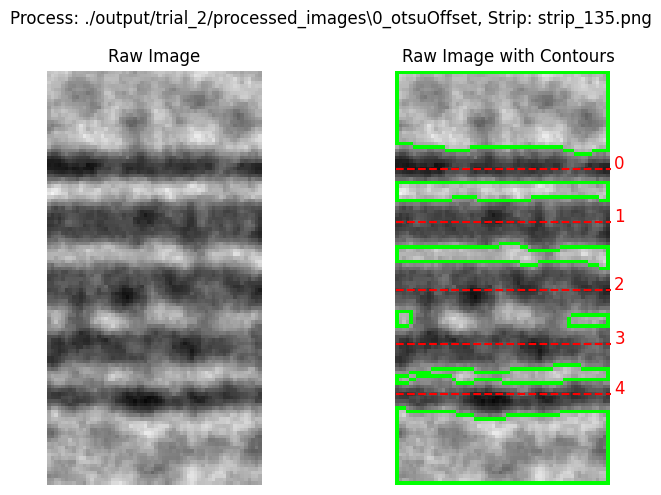

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 161
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_161.png


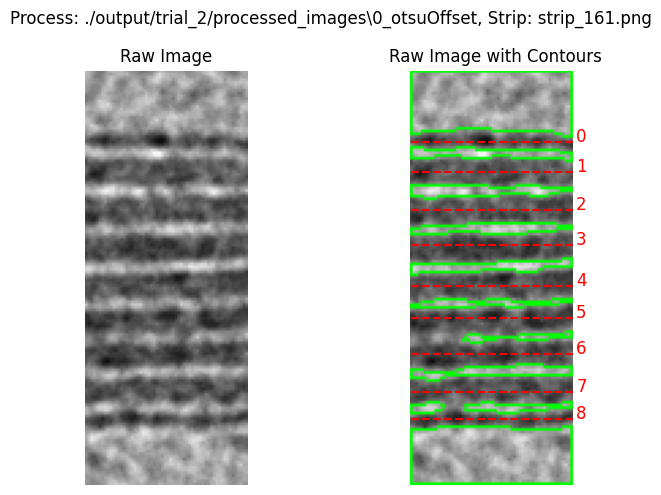

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 176
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_176.png


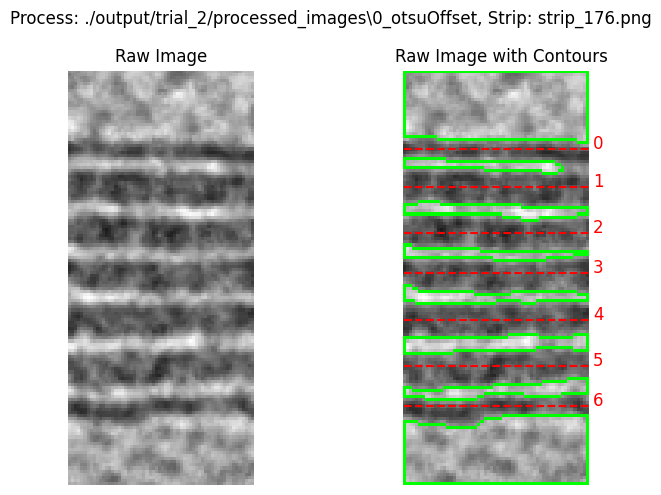

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 187
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_187.png


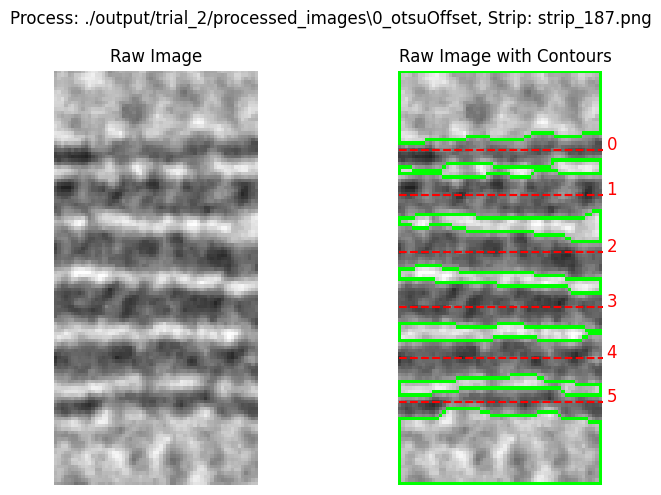

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 229
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_229.png


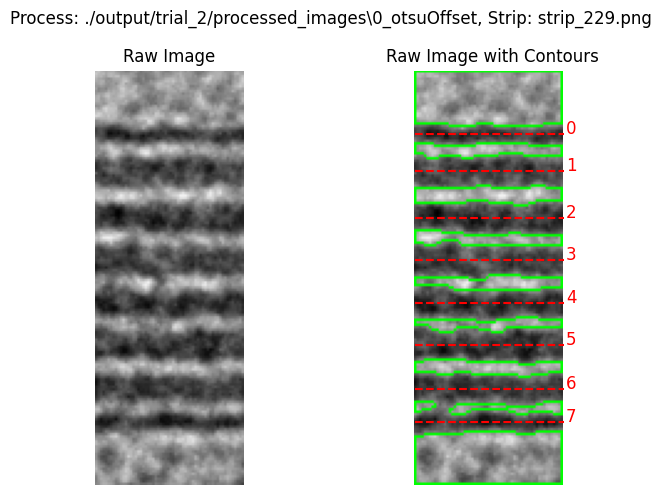

Membrane data path: ./output/trial_2/processed_images\0_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 232
Image written to ./output/trial_2/processed_images\0_otsuOffset\contours\strip_232.png


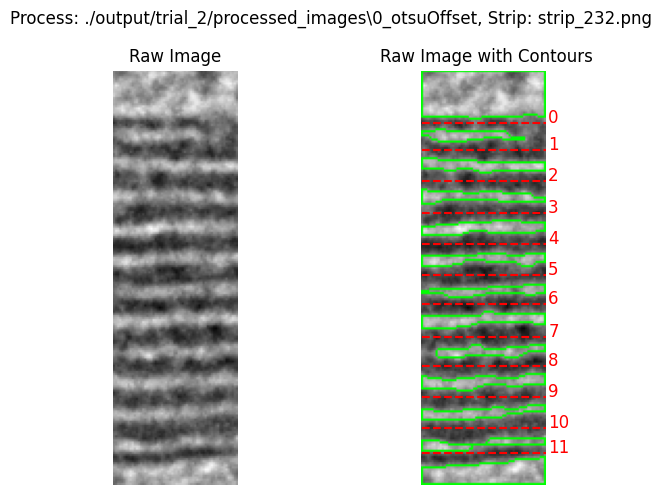

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_101.png


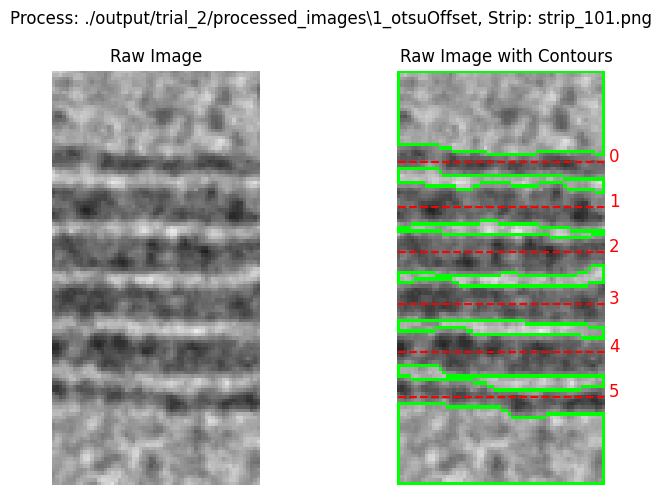

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 106
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_106.png


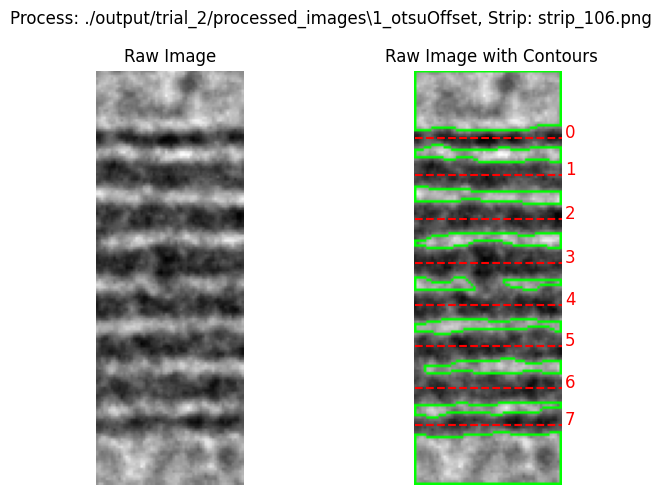

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 134
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_134.png


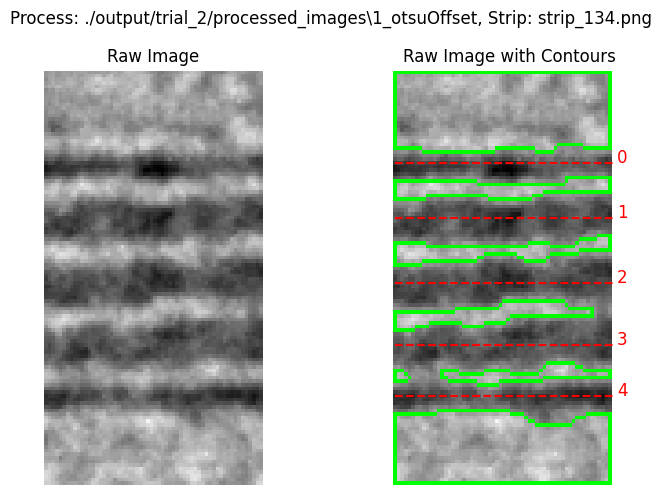

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 135
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_135.png


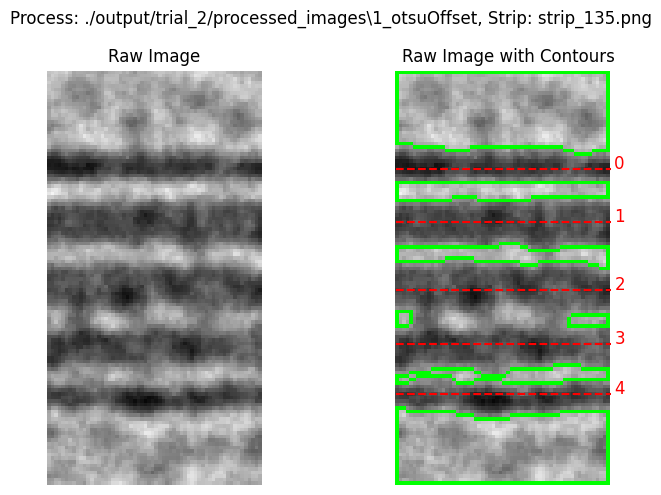

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 161
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_161.png


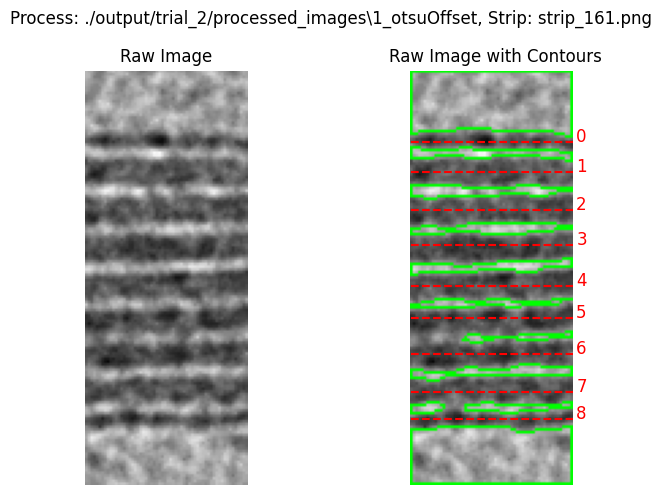

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 176
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_176.png


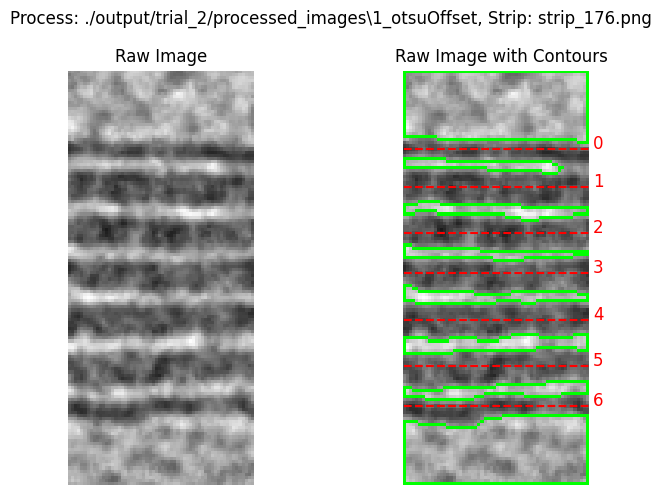

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 187
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_187.png


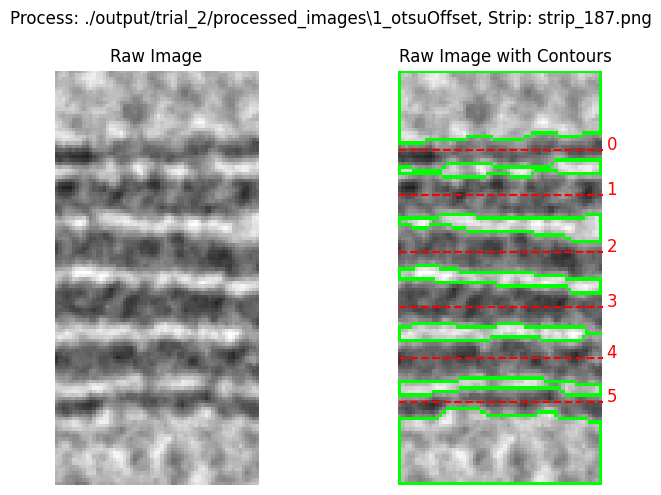

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 229
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_229.png


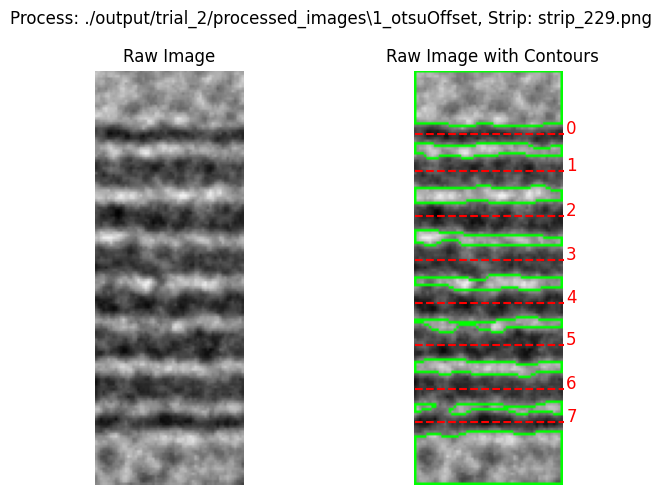

Membrane data path: ./output/trial_2/processed_images\1_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 232
Image written to ./output/trial_2/processed_images\1_otsuOffset\contours\strip_232.png


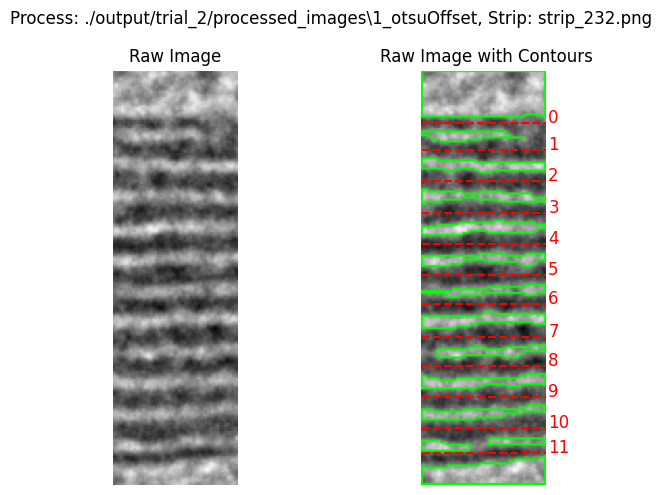

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_101.png


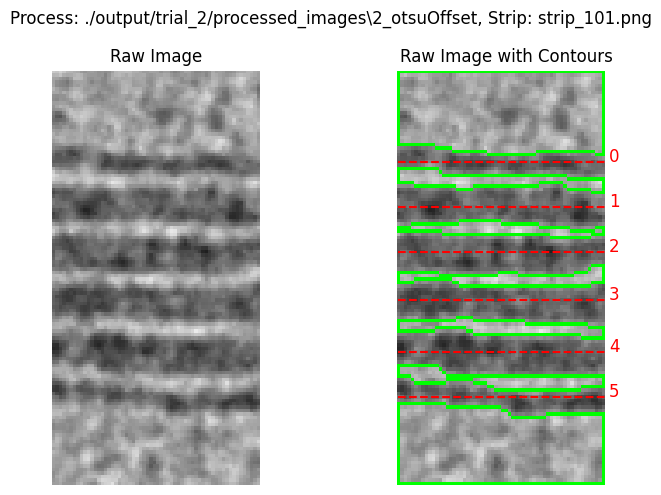

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 106
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_106.png


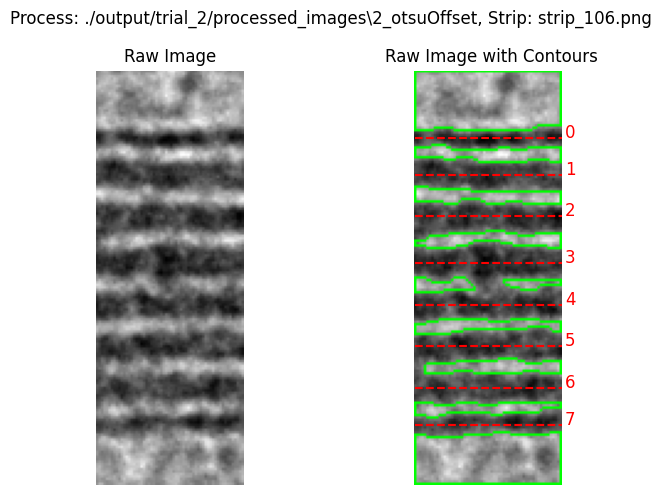

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 134
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_134.png


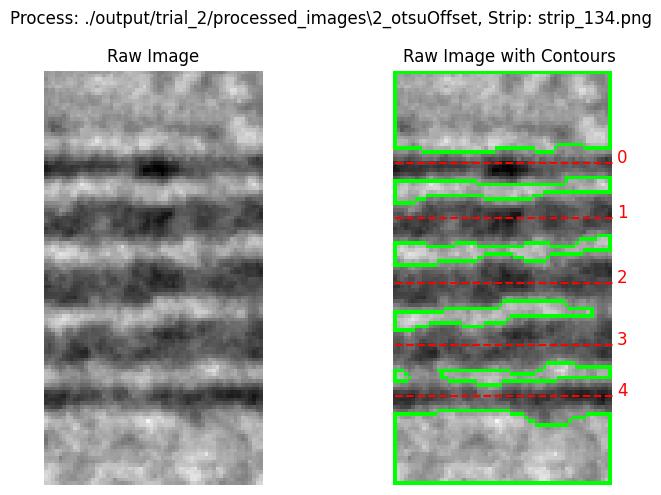

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 135
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_135.png


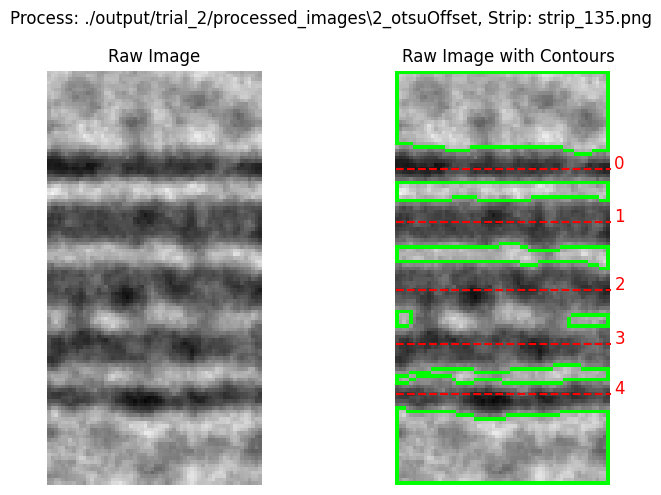

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 161
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_161.png


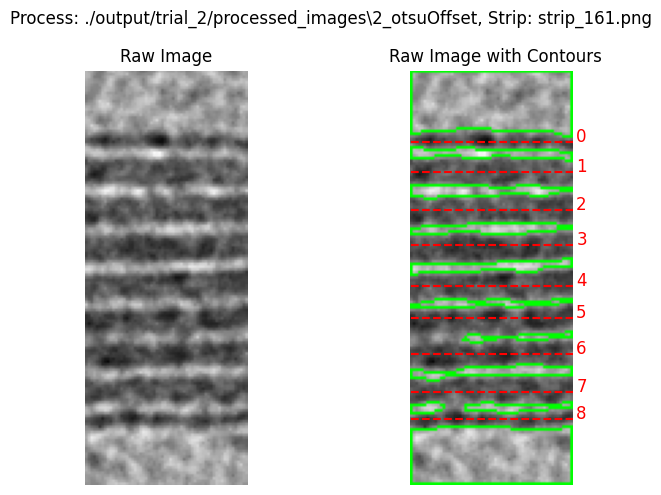

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 176
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_176.png


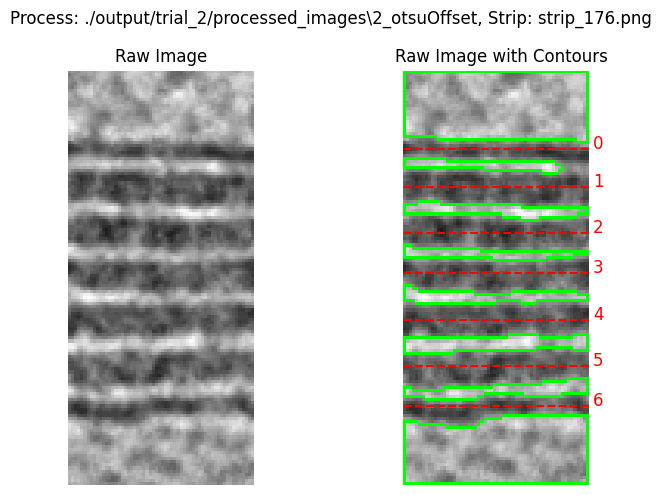

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 187
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_187.png


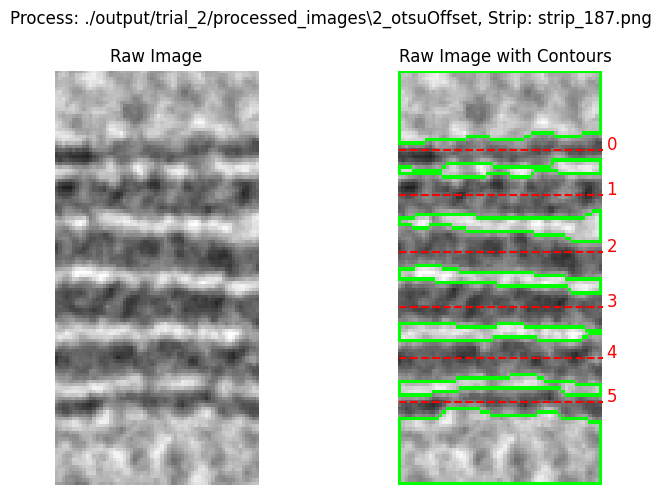

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 229
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_229.png


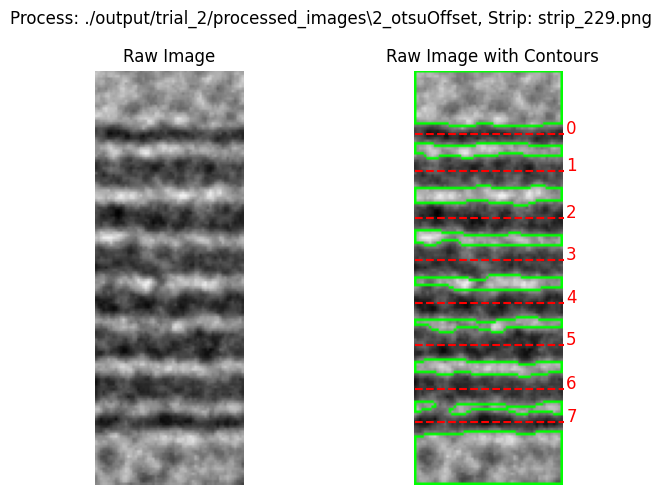

Membrane data path: ./output/trial_2/processed_images\2_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 232
Image written to ./output/trial_2/processed_images\2_otsuOffset\contours\strip_232.png


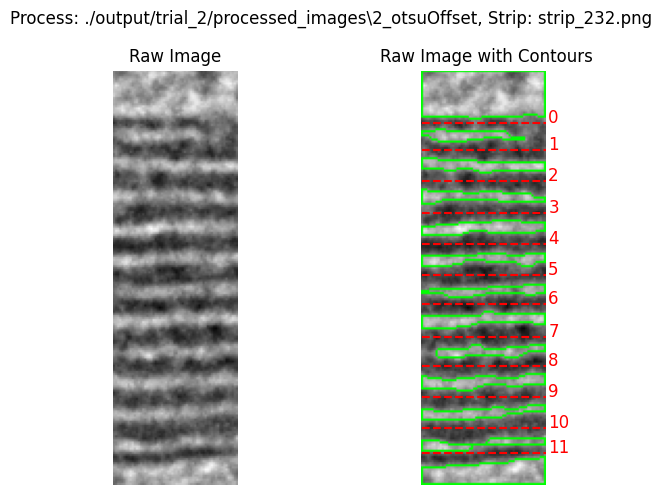

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_101.png


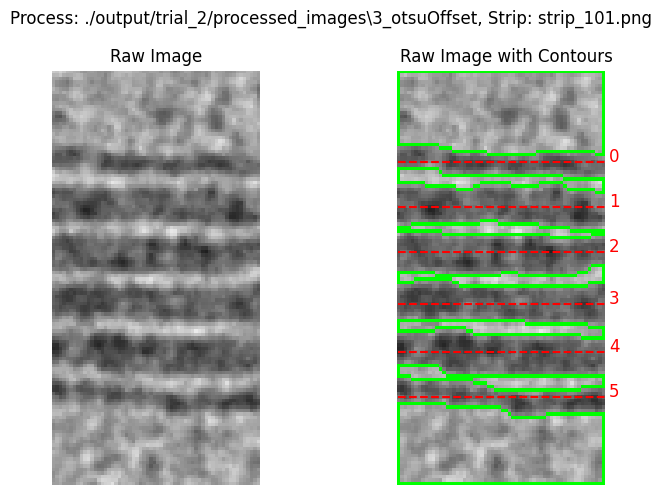

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 106
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_106.png


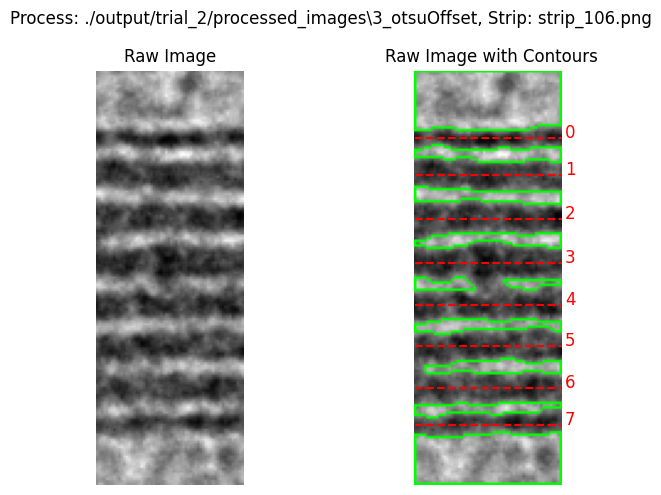

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 134
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_134.png


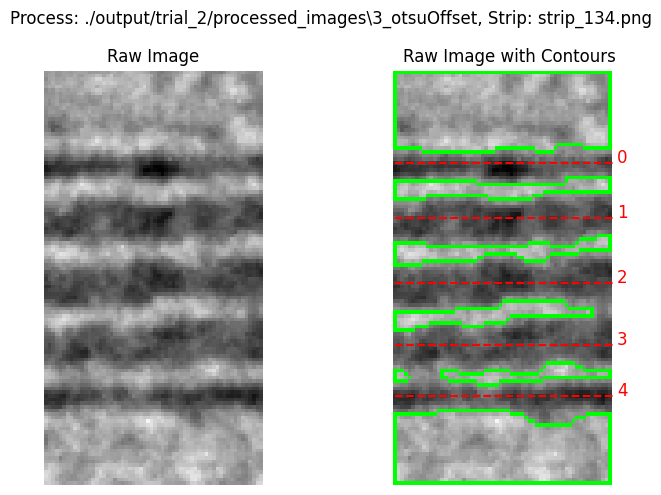

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 135
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_135.png


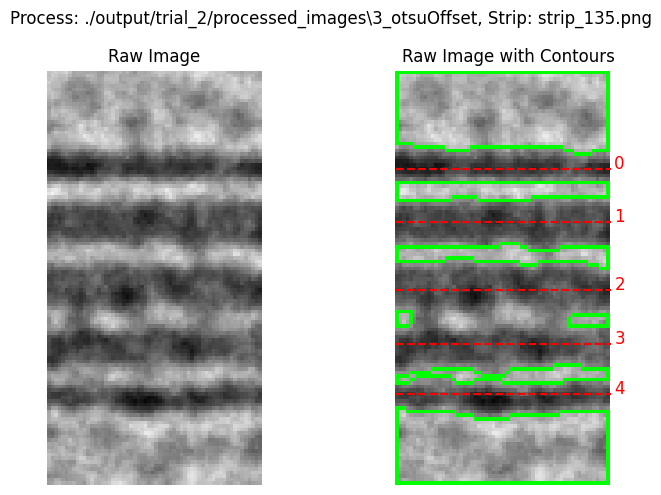

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 161
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_161.png


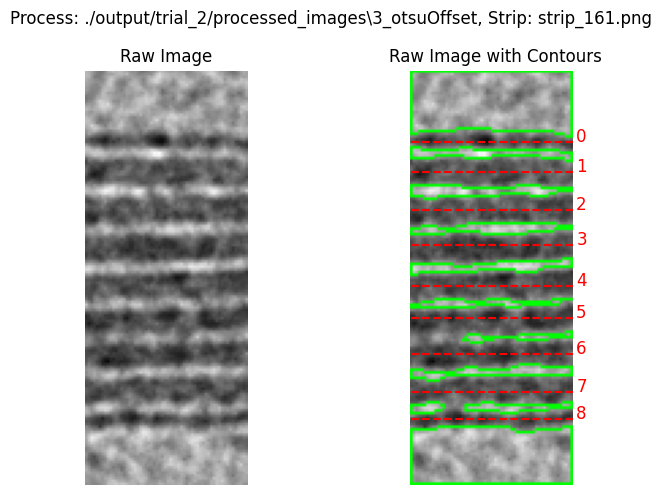

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 176
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_176.png


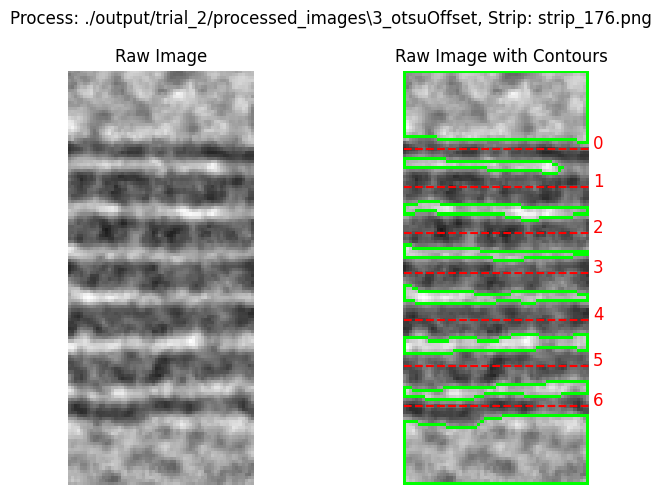

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 187
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_187.png


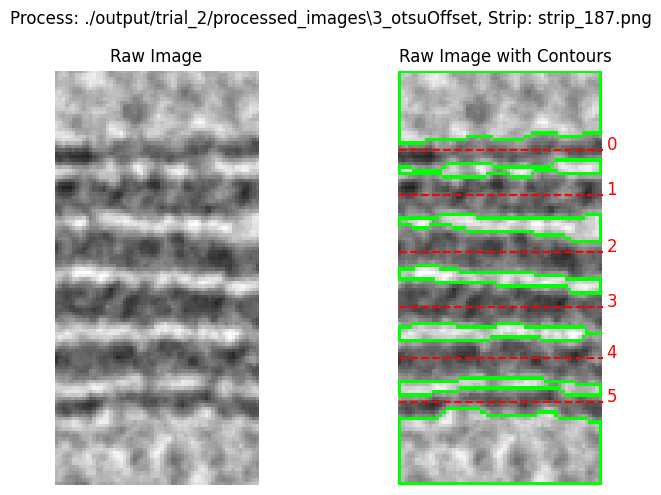

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 229
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_229.png


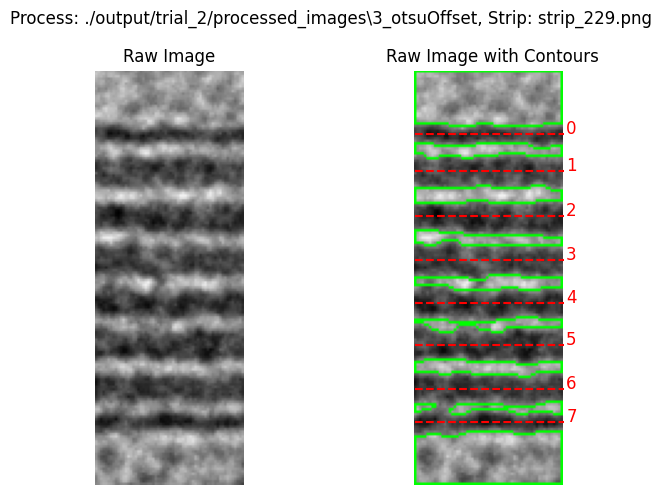

Membrane data path: ./output/trial_2/processed_images\3_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 232
Image written to ./output/trial_2/processed_images\3_otsuOffset\contours\strip_232.png


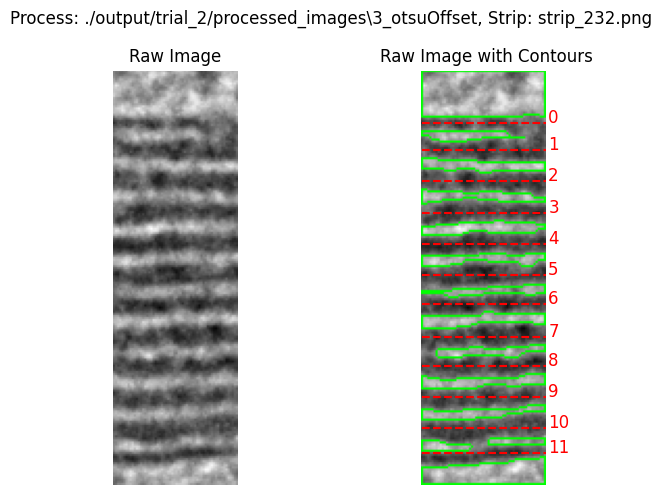

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_101.png


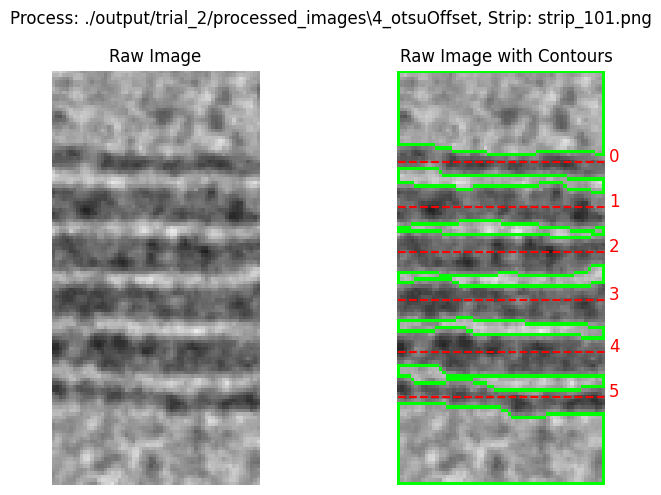

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 106
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_106.png


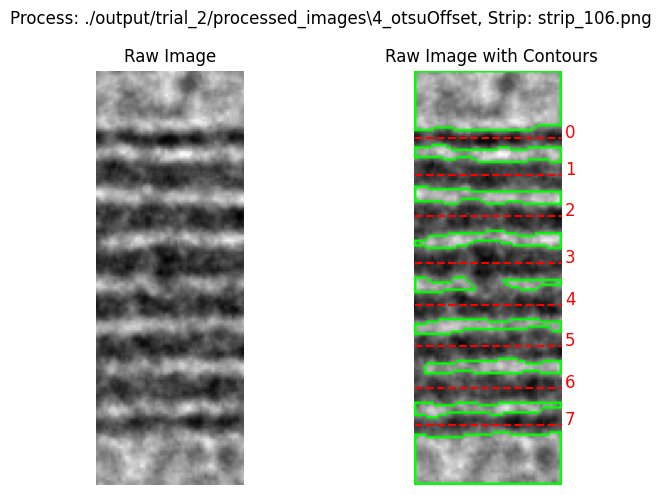

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 134
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_134.png


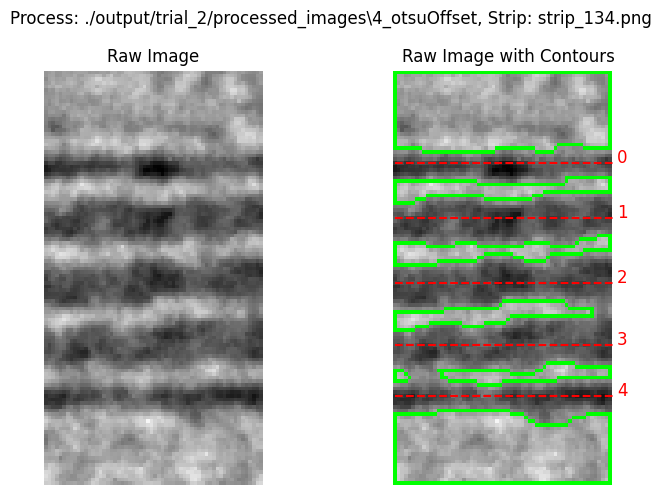

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 135
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_135.png


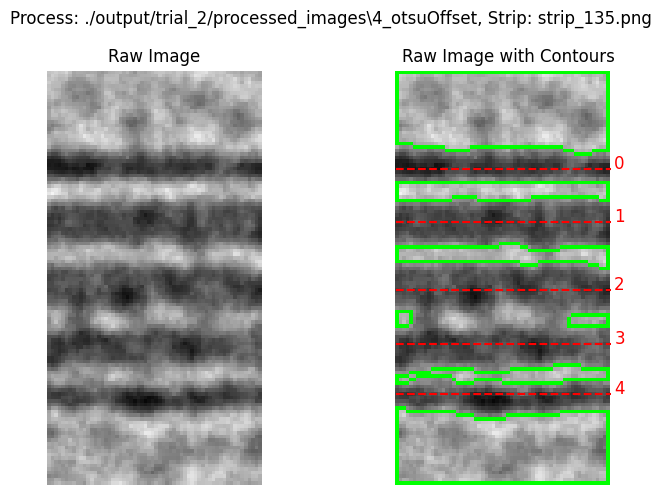

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 161
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_161.png


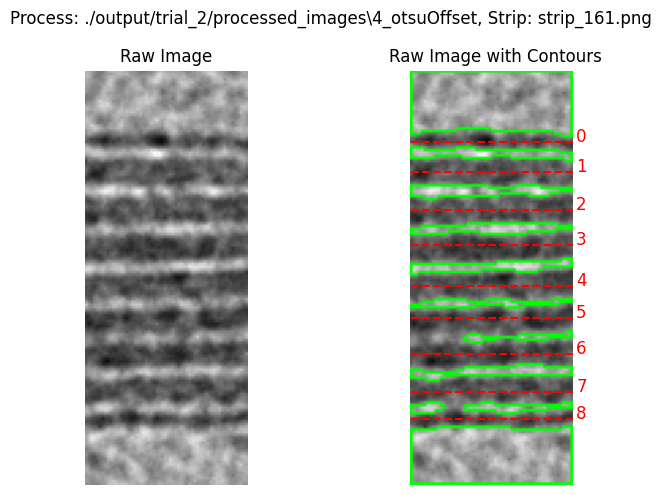

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 176
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_176.png


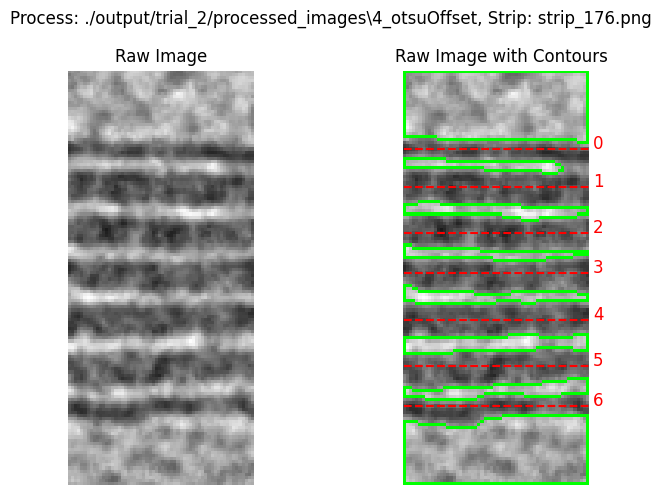

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 187
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_187.png


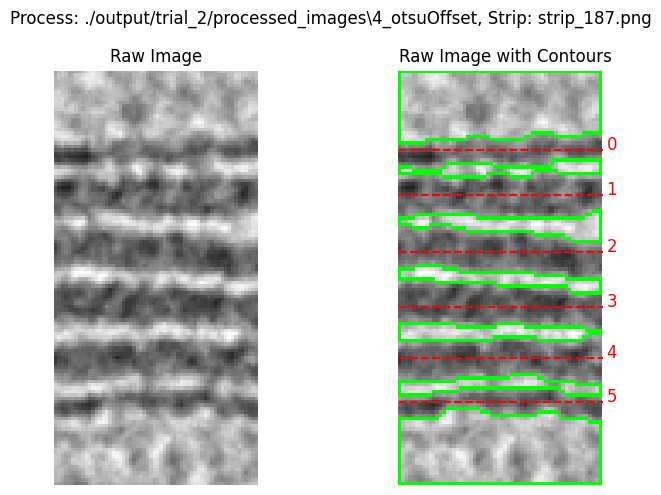

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 229
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_229.png


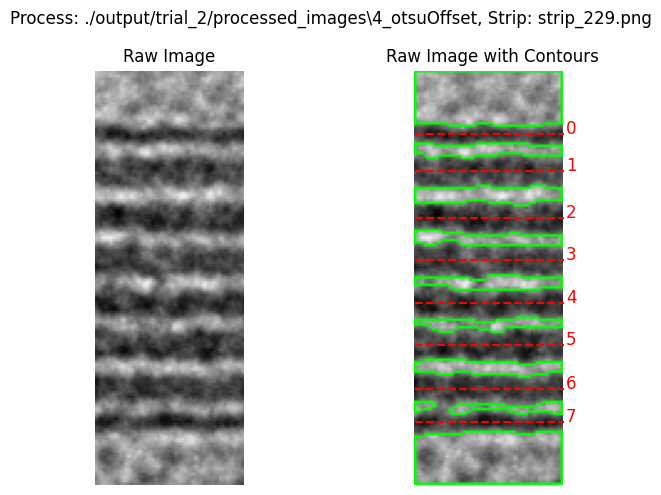

Membrane data path: ./output/trial_2/processed_images\4_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 232
Image written to ./output/trial_2/processed_images\4_otsuOffset\contours\strip_232.png


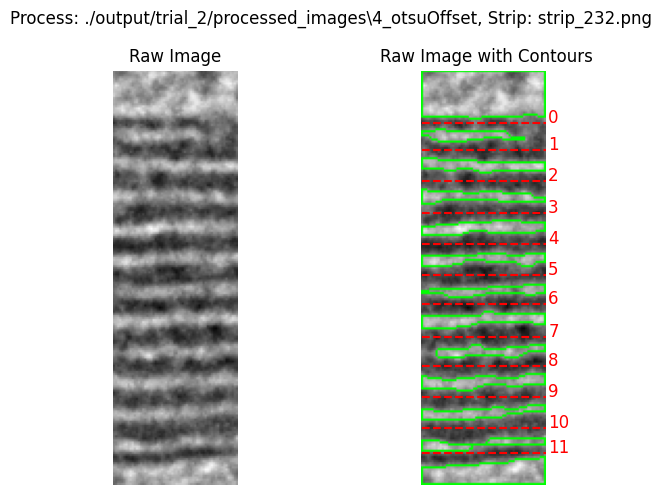

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 101
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_101.png


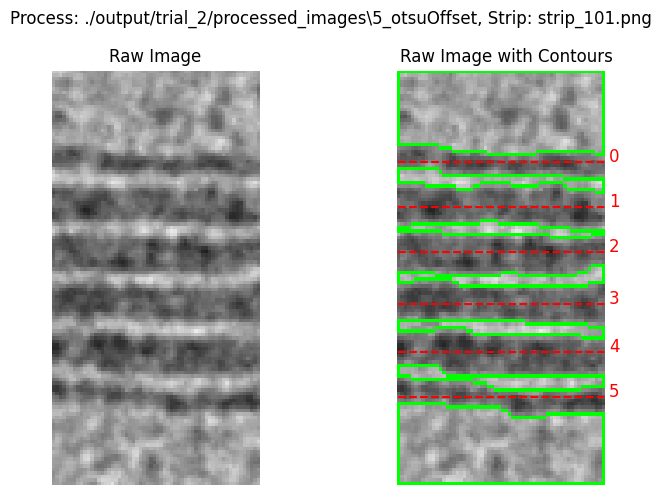

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 106
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_106.png


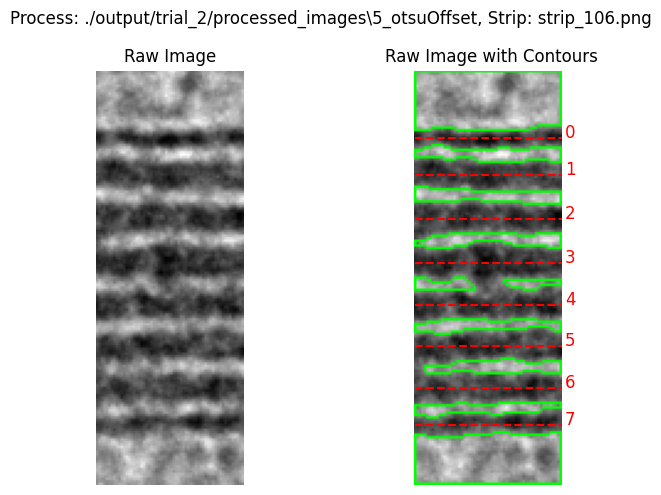

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 134
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_134.png


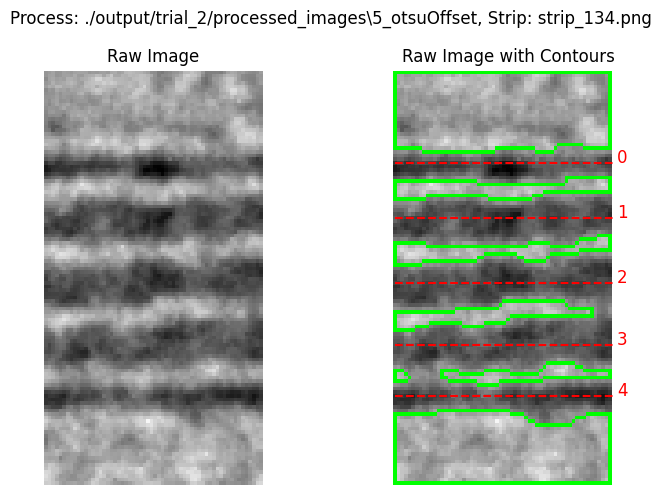

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 135
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_135.png


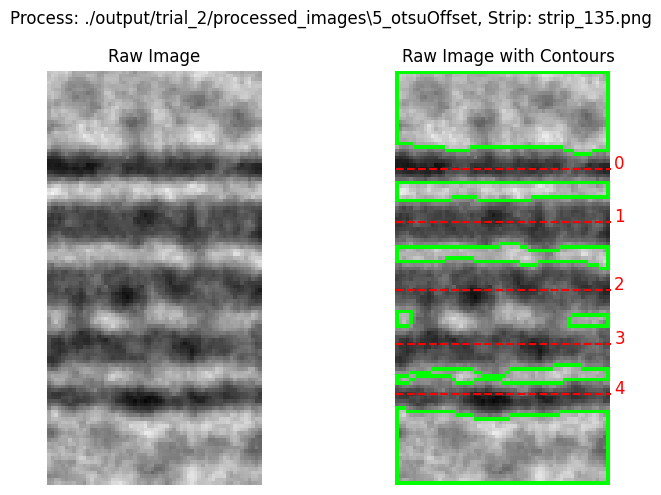

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 161
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_161.png


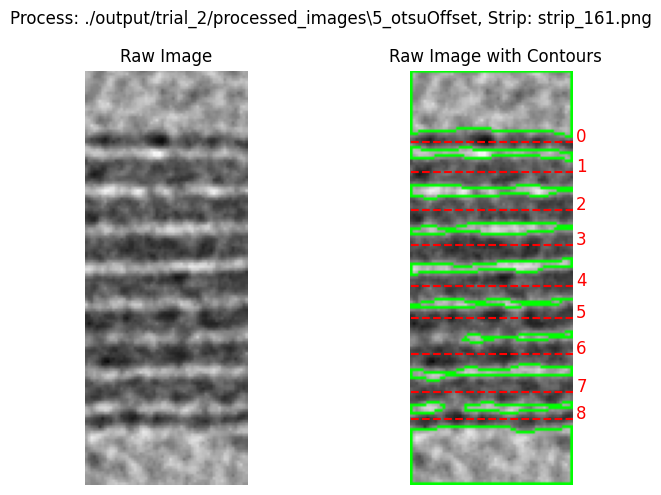

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 176
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_176.png


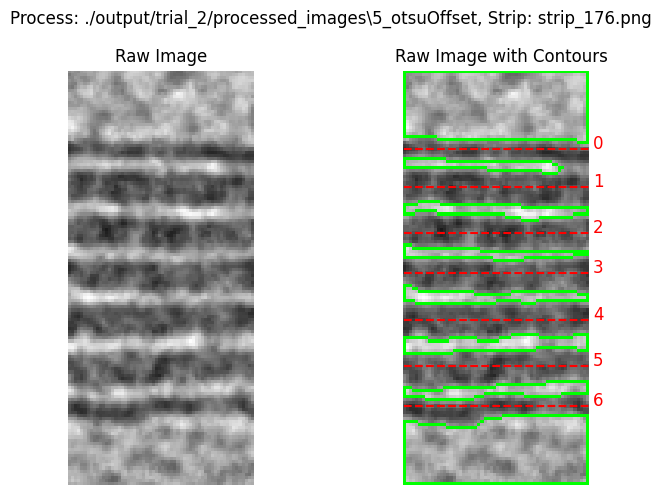

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 187
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_187.png


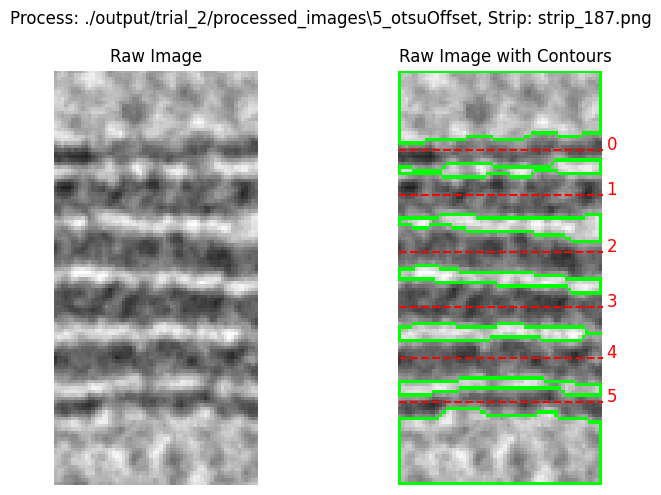

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 229
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_229.png


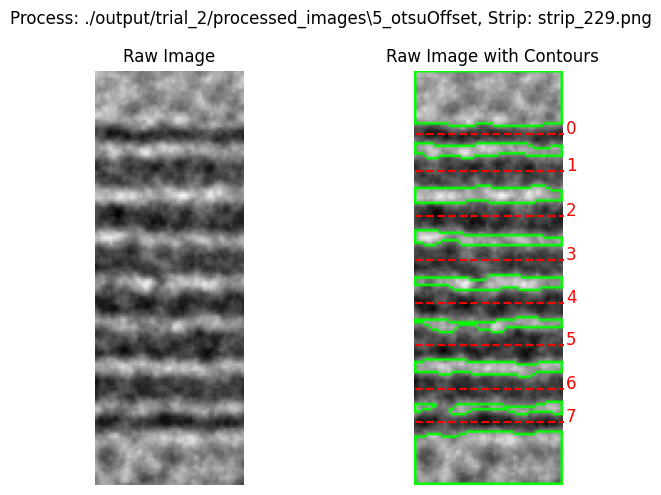

Membrane data path: ./output/trial_2/processed_images\5_otsuOffset\grana_data_membrane.csv
len(membrane_data): 66
Strip: 232
Image written to ./output/trial_2/processed_images\5_otsuOffset\contours\strip_232.png


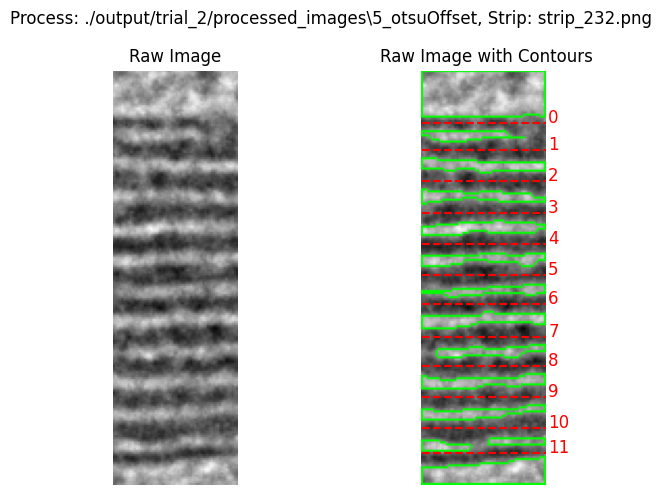

In [16]:
from itertools import product

combinations = list(product(process_folders, strip_filenames))

for process, strip in combinations:
    membrane_image = getMembraneImage(process, strip)
    raw_image = getRawImage(roi_folder, strip)
    df = getMembraneDf(process, strip)
    raw_image_with_contours = drawContours(membrane_image, raw_image, color=(0, 255, 0), thickness=1)
    
    # create an output folder for the raw_vs_contours images
    raw_vs_contours_folder = os.path.join(process, 'raw_vs_contours')
    os.makedirs(raw_vs_contours_folder, exist_ok=True)
    raw_vs_contours_path = os.path.join(raw_vs_contours_folder, strip)
    
    # use opencv to write the image to the process_folder/contours folder
    contours_folder = os.path.join(process, 'contours')
    os.makedirs(contours_folder, exist_ok=True)
    contours_image_path = os.path.join(contours_folder, strip)

    cv2.imwrite(contours_image_path, raw_image_with_contours)
    print(f"Image written to {contours_image_path}")

    fig, axes = plt.subplots(1, 2, figsize=(8, 5))


    # Plot raw_image on the left
    axes[0].imshow(raw_image, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Raw Image')

    # Plot raw_image_with_contours on the right
    axes[1].imshow(raw_image_with_contours)
    axes[1].axis('off')
    axes[1].set_title('Raw Image with Contours')

    if df is not None:
        # get the peaks from the df
        peaks = df['peaks'].values
        # for each peak, plot the peak number at the y value of the peak
        for i, peak in enumerate(peaks):
            # draw a dashed line at the peak
            axes[1].plot([0, raw_image_with_contours.shape[1]], [peak, peak], 'r--')
            # add a text label for the peak, in red
            axes[1].text(raw_image_with_contours.shape[1] + 1, peak, f"{i}", color='red', fontsize=12)

    plt.suptitle(f'Process: {process}, Strip: {strip}')
    plt.tight_layout()
    
    plt.savefig(raw_vs_contours_path)
    plt.show()